In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from core import med_log_odds_cutoff, high_log_odds_cutoff, bw_color_palette
from tqdm import tqdm
import textwrap
from joblib import Parallel, delayed
import gpplot

In [3]:
def select_domains(hhblits_df, prob_cutoff=50):
    # Other Domains
    out_list = []
    for group, group_df in tqdm(hhblits_df[(hhblits_df['Prob'] > prob_cutoff)].groupby('query'), 
                                position=0, total=hhblits_df['query'].nunique()):
        group_df = group_df.sort_values('Prob', ascending=False)
        while len(group_df):
            selected_row = group_df.head(1).squeeze()
            out_list.append(selected_row)
            group_df = group_df[(group_df['qend'] < selected_row['qstart']) |
                                (group_df['qstart'] > selected_row['qend'])]
    selected_domain_df = pd.concat(out_list, axis=1).T
    return selected_domain_df

In [4]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7

In [5]:
def assign_hit_category(row):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    elif row['q_cov'] > 0.5:
        return 'Remote defense homolog'
    else:
        return 'Predicted novel defense gene'

In [6]:
predictions = pd.read_csv('../data/processed/refseq_500_predictions.csv')
cluster_df = pd.read_table('../data/interim/refseq_500_mmseqs/seq_clusters.txt', names=['cluster_id', 'product_accession'])
hhpred_results = pd.read_csv('../data/interim/refseq_500_putative_novel_hhdb_domains.csv')

/state/partition1/slurm_tmp/27708111.0.0/ipykernel_375316/204332814.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  predictions = pd.read_csv('../data/processed/refseq_500_predictions.csv')


In [7]:
all_predictions_merged = (predictions.merge(cluster_df, how='inner', on='product_accession'))
all_predictions_merged['log_odds'] = np.log(all_predictions_merged['beaker_prediction']/(1-all_predictions_merged['beaker_prediction']))
all_predictions_merged['defensive'] = all_predictions_merged['log_odds'] > med_log_odds_cutoff

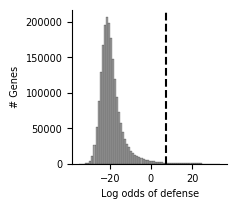

In [8]:
plt.subplots(figsize=(2,2))
sns.histplot(all_predictions_merged['log_odds'], binwidth=1, 
             color='grey')
plt.xlabel('Log odds of defense')
plt.ylabel('# Genes')
plt.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()

In [9]:
assembly_clusters_df = (all_predictions_merged
                        [['cluster_id', 'assembly']].drop_duplicates())

In [10]:
cluster_count = assembly_clusters_df['cluster_id'].value_counts()

In [11]:
assemblies = assembly_clusters_df['assembly'].drop_duplicates()
n_assemblies = len(assemblies)

In [12]:
n_assemblies

500

In [13]:
len(cluster_count)

337548

In [14]:
(cluster_count <= 10).sum()

314572

In [15]:
(cluster_count >= 400).sum()

130

In [16]:
cluster_count[cluster_count >= 498]

cluster_id
WP_001096198.1    498
Name: count, dtype: int64

In [17]:
cluster_count[cluster_count]

cluster_id
WP_241224595.1    265
WP_016241527.1    265
WP_000049198.1    266
WP_268603661.1    266
WP_210764025.1    267
                 ... 
WP_001138117.1    497
WP_001138117.1    497
WP_001138117.1    497
WP_001138117.1    497
WP_001138117.1    497
Name: count, Length: 337548, dtype: int64

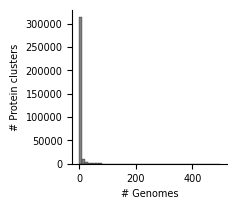

In [18]:
plt.subplots(figsize=(2,2))
sns.histplot(cluster_count, binwidth=10, color='grey', alpha=1)
sns.despine()
plt.xlabel('# Genomes')
plt.ylabel('# Protein clusters')
plt.savefig('../figures/refseq_500_u_plot.svg', dpi=300, bbox_inches='tight')

In [19]:
assemblies = assembly_clusters_df['assembly'].drop_duplicates()

In [20]:
def sample_clusters(n, n_boot, assemblies, assembly_clusters_df):
    out_list = list()
    for boot in range(n_boot):
        sampled_assemblies = assemblies.sample(n=n, random_state=boot).to_list()
        n_clusters = assembly_clusters_df.loc[assembly_clusters_df['assembly'].isin(sampled_assemblies), 
                                              'cluster_id'].nunique()
        out_dict = {'n_assemblies': n,
                    'n_clusters': n_clusters, 
                    'boot': boot}
        out_list.append(out_dict)
    out_df = pd.DataFrame(out_list)
    return out_df

In [21]:
n_samples = [int(x) for x in np.linspace(1, 500, num=50)]
n_boot = 50

In [22]:
out_df_list = Parallel(n_jobs=40)(delayed(sample_clusters)(n, n_boot, assemblies, assembly_clusters_df) for n in tqdm(n_samples))

100%|██████████| 50/50 [00:01<00:00, 30.35it/s]


In [23]:
out_df = pd.concat(out_df_list)

In [24]:
agg_out_df = (out_df.groupby('n_assemblies')
              .agg({'n_clusters': 'mean'})
              .reset_index())

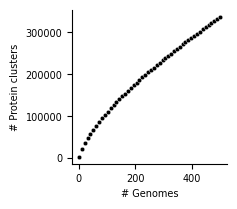

In [25]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_out_df, x='n_assemblies', y='n_clusters',
                color='black', s=10)
sns.despine()
plt.xlabel('# Genomes')
plt.ylabel('# Protein clusters')
plt.savefig('../figures/refseq_500_clusters_per_assembly.svg', dpi=300, bbox_inches='tight')

In [26]:
def count_systems(assembly, assembly_df, dp_operon_dist):
    n_df_systems = assembly_df['defense_system'].nunique()
    assembly_df = assembly_df.sort_values(['genomic_accession', 'start']).reset_index(drop=True)
    operon = 0
    prev_end = None
    prev_strand = None
    operon_list = list()
    for _, row in assembly_df.iterrows():
        if prev_end is not None:
            if (prev_strand != row['strand']) or (abs(prev_end - row['start']) > dp_operon_dist):
                operon += 1
        operon_list.append(operon)
        prev_end = row['end']
        prev_strand = row['strand']
    assembly_df['operon'] = operon_list
    assembly_pred_defense = assembly_df.query('predicted_defensive')
    n_dp_systems = assembly_pred_defense['operon'].nunique()
    system_count_dict = {'assembly': assembly, 
                         '# DefenseFinder Systems': n_df_systems, 
                         '# DefensePredictor Systems': n_dp_systems}
    return system_count_dict
    

In [27]:
dp_operon_dist = 30
system_count_list = Parallel(n_jobs=40)(delayed(count_systems)(assembly, assembly_df, dp_operon_dist) for assembly, assembly_df in tqdm(all_predictions_merged.groupby('assembly')))

100%|██████████| 500/500 [00:04<00:00, 116.99it/s]


In [28]:
system_count_df = pd.DataFrame(system_count_list)
assembly_size = (predictions.groupby('assembly')
                 .agg(n_proteins=('product_accession', 'count'))
                 .reset_index())
system_count_df = system_count_df.rename(columns={'# DefenseFinder Systems': 'DefenseFinder', 
                                                  '# DefensePredictor Systems': 'DefensePredictor'})
system_count_df = system_count_df.merge(assembly_size, how='inner', on='assembly')
system_count_df['DefenseFinder_per_protein'] = system_count_df['DefenseFinder']/system_count_df['n_proteins']
system_count_df['DefensePredictor_per_protein'] = system_count_df['DefensePredictor']/system_count_df['n_proteins']

In [29]:
system_count_df.sort_values('DefensePredictor', ascending=True).head(20)

,assembly,DefenseFinder,DefensePredictor,n_proteins,DefenseFinder_per_protein,DefensePredictor_per_protein
499,GCF_936981045.1,0,0,805,0.000000,0.000000
496,GCF_902806995.1,1,0,979,0.001021,0.000000
134,GCF_002774925.1,0,0,844,0.000000,0.000000
156,GCF_003285265.1,0,0,3084,0.000000,0.000000
441,GCF_900048045.1,0,0,255,0.000000,0.000000
29,GCF_000319245.1,0,0,736,0.000000,0.000000
28,GCF_000292685.1,0,0,249,0.000000,0.000000
372,GCF_018107685.1,0,0,669,0.000000,0.000000
295,GCF_012568845.1,0,0,399,0.000000,0.000000
16,GCF_000166935.1,0,1,1289,0.000000,0.000776


In [30]:
system_count_df[['DefenseFinder', 'DefensePredictor']].mean(axis=0)

DefenseFinder        6.238
DefensePredictor    27.404
dtype: float64

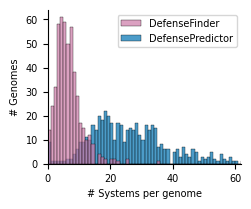

In [31]:
plt.subplots(figsize=(2.5, 2))
sns.histplot(data=system_count_df[['DefenseFinder', 'DefensePredictor']], binwidth=1, palette=[bw_color_palette[6],bw_color_palette[4]], alpha=0.7, 
             linewidth=0.25)
plt.xlim(0, 62)
sns.despine()
plt.xlabel('# Systems per genome')
plt.ylabel('# Genomes')
plt.savefig('../figures/system_per_genome_comparison_refseq_500.svg', dpi=300, bbox_inches='tight')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

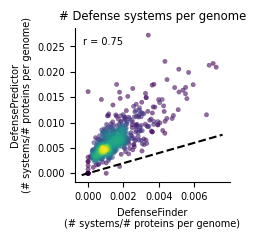

In [32]:
plt.subplots(figsize=(2,2))
gpplot.point_densityplot(data=system_count_df, 
                         x='DefenseFinder_per_protein', y='DefensePredictor_per_protein',  
                         s=10)
gpplot.add_correlation(data=system_count_df, x='DefenseFinder_per_protein', y='DefensePredictor_per_protein')
plt.xlabel('DefenseFinder\n(# systems/# proteins per genome)')
plt.ylabel('DefensePredictor\n(# systems/# proteins per genome)')
sns.despine()
gpplot.add_xy_line()
plt.title('# Defense systems per genome')
plt.savefig('../figures/systems_df_dp.svg', dpi=300, bbox_inches='tight')

In [33]:
filtered_predictions = all_predictions_merged[all_predictions_merged['log_odds'] > med_log_odds_cutoff].copy()
filtered_predictions['accession_stub'] = (filtered_predictions['product_accession']
                                          .str.split('.', expand=True)[0])

In [34]:
hhpred_results['q_ali_len'] = hhpred_results['qend'] - hhpred_results['qstart']
remote_defense_homologs = (hhpred_results[hhpred_results['hit_name'].str.contains('~') &
                                          (hhpred_results['Prob'] > 50)]
                           .sort_values('q_ali_len', ascending=False)
                           .groupby('query')
                           .head(1)
                           .merge(filtered_predictions[['accession_stub', 'product_accession', 'product_length']].drop_duplicates(), 
                                  how='left', left_on='query', right_on='accession_stub'))
remote_defense_homologs['q_cov'] = remote_defense_homologs['q_ali_len']/remote_defense_homologs['product_length']


In [35]:
merged_predictions = (filtered_predictions.merge(
    remote_defense_homologs[['product_accession', 'hit_name', 'q_cov', 'Prob']], how='left', 
                                                   on='product_accession'))
merged_predictions['q_cov'] = merged_predictions['q_cov'].fillna(0)
merged_predictions['hit_category'] = merged_predictions.apply(assign_hit_category, axis=1)
merged_predictions['hit_category'] = pd.Categorical(merged_predictions['hit_category'], 
                                                    categories=['Defense homolog in expected system',
                                                                'Defense homolog in new context', 
                                                                'Remote defense homolog', 
                                                                'Predicted novel defense gene'])


In [36]:
merged_predictions['hit_category'].value_counts()

hit_category
Defense homolog in expected system    6331
Defense homolog in new context        5543
Predicted novel defense gene          5256
Remote defense homolog                2765
Name: count, dtype: int64

In [37]:
unique_merged_predictions = (merged_predictions.sort_values(by=['hit_category', 'log_odds'], ascending=[True, False])
                             .groupby('cluster_id')
                             .head(1))

In [38]:
unique_merged_predictions['hit_category'].value_counts()

hit_category
Predicted novel defense gene          3376
Defense homolog in expected system    1927
Remote defense homolog                1295
Defense homolog in new context        1024
Name: count, dtype: int64

In [39]:
genomes = predictions['assembly'].drop_duplicates()
len(genomes)

500

In [40]:
sample_range = [int(x) for x in np.linspace(1, len(genomes), num=50)]
n_boot = 50
n_def_cluster_list = list()
for n in tqdm(sample_range):
    for boot in range(n_boot):
        sampled_genomes = genomes.sample(n=n, random_state=boot)
        sampled_def_df = merged_predictions[merged_predictions['assembly'].isin(sampled_genomes)]
        unique_sampled_def_df = (sampled_def_df.sort_values(by=['hit_category', 'log_odds'], ascending=[True, False])
                                 .groupby('cluster_id')
                                 .head(1))
        n_def_clusters = (unique_sampled_def_df['hit_category']
                          .value_counts()
                          .reset_index())
        n_def_clusters['n_genomes'] = n
        n_def_clusters['boot'] = boot
        n_def_cluster_list.append(n_def_clusters)
cat_n_def_cluster = pd.concat(n_def_cluster_list)

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


In [41]:
agg_n_def_cluster = (cat_n_def_cluster.groupby(['n_genomes', 'hit_category'])
                     .agg({'count': 'mean'})
                     .reset_index())

In [42]:
agg_n_def_cluster['predicted_category'] = pd.Categorical(agg_n_def_cluster['hit_category'], 
                                                         categories=['Defense homolog in expected system', 
                                                                     'Defense homolog in new context', 
                                                                     'Remote defense homolog', 
                                                                     'Predicted novel defense gene'])

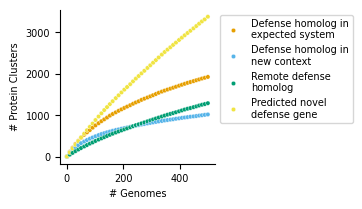

In [43]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_n_def_cluster, x='n_genomes', y='count', hue='hit_category',
              palette=bw_color_palette[:4], s=10)
sns.despine()
# Adjust legend
legend = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
handles, labels = legend.get_texts(), [text.get_text() for text in legend.get_texts()]
wrapped_labels = [textwrap.fill(label, 20) for label in labels]
for text, wrapped_label in zip(handles, wrapped_labels):
    text.set_text(wrapped_label)
# Other plot attributes
plt.ylabel('# Protein Clusters')
plt.xlabel('# Genomes')
plt.savefig('../figures/refseq500_predicted_category_per_genome.svg', dpi=300, bbox_inches='tight')

In [74]:
# output predictions
unique_merged_predictions[unique_merged_predictions['hit_category'] == 'Predicted novel defense gene'].to_csv('../data/processed/refseq_500_novel_defense.csv', index=False)
predictions[['assembly']].drop_duplicates().to_csv('../data/processed/refseq_500_assemblies.csv', index=False)


### System analysis

In [44]:
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', 
                           names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])
blacklisted_domains = pd.read_csv('../data/interim/df_blacklisted_domains.csv')

In [45]:
novel_accessions = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                          'product_accession'].drop_duplicates()
n_partial_align = remote_defense_homologs['product_accession'].isin(novel_accessions).sum()
print('# predicted novel defense genes with partial alignment:', n_partial_align)
print('Frac with partial alignment', n_partial_align/len(novel_accessions))

# predicted novel defense genes with partial alignment: 2605
Frac with partial alignment 0.49685294678619113


TODO: Get clusters

In [ ]:
cluster_n_genomes = (predictions.groupby('cluster_id')
                     .agg(n_genomes=('assembly', 'nunique'))
                     .reset_index())
predicted_novel_defense_clusters = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                                          ['cluster_id']].drop_duplicates()
pnd_clusters_n_genomes = (predicted_novel_defense_clusters.merge(cluster_n_genomes, 
                                                                how='inner', on='cluster_id'))
pnd_clusters_n_genomes['category'] = 'Predicted novel\ndefense genes'
known_defense_clusters = predictions.loc[predictions['defense_system_protein'], 
                                         ['cluster_id']].drop_duplicates()
kd_clusters_n_genomes = (known_defense_clusters.merge(cluster_n_genomes, 
                                                      how='inner', on='cluster_id'))
kd_clusters_n_genomes['category'] = 'All defense homologs\nin expected systems'
cluster_n_genomes['category'] = 'All genes'
cluster_categories_n_genomes = pd.concat([cluster_n_genomes, pnd_clusters_n_genomes, kd_clusters_n_genomes], axis=0)
cluster_categories_n_genomes['category'] = pd.Categorical(cluster_categories_n_genomes['category'], 
                                                              categories=['All genes',
                                                                  'All defense homologs\nin expected systems',
                                                                'Predicted novel\ndefense genes'])

In [ ]:
g = sns.displot(data=cluster_categories_n_genomes, x='n_genomes', binwidth=2, 
                hue='category', palette=(['grey', '#e69f00', '#f0e442']), 
                col='category', kind='hist', facet_kws={'sharey': False}, 
                alpha=1, height=2, legend=False, aspect=0.9)
g.set_titles(template='{col_name}')
g.set_xlabels('# Genomes')
g.set_ylabels('# Gene clusters')
g.figure.subplots_adjust(wspace=0.3)
plt.savefig('../figures/cluster_distribution.svg', dpi=300, bbox_inches='tight')

In [46]:
pfam_results = hhpred_results[(hhpred_results['hit_name'].str[:2] == 'PF') & 
                              (hhpred_results['Prob'] > 50)].copy()
pfam_results['pfam_id'] = pfam_results['hit_name'].str.split('.', expand=True)[0]
pfam_results = pfam_results.merge(pfam_clans, how='left', on='pfam_id')

In [51]:
novel_accession_stubs = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                          'accession_stub'].drop_duplicates()
novel_pfam_results = pfam_results[pfam_results['query'].isin(novel_accession_stubs)]
novel_pfam_clans = (novel_pfam_results[['query', 'clan_name']]
                    .drop_duplicates())

In [52]:
novel_pfam_clan_count = (novel_pfam_clans.groupby('clan_name')
                         .agg(count=('query', 'count'))
                         .rename(index={'P-loop_NTPase': 'P-loop NTPase', 
                                        'PDDEXK': 'PDDEXK nuclease', 
                                        'PEP-carboxyk': 'PEP carboxykinase',
                                        'Met_repress': 'RHH antitoxin DNA binding', 
                                        'KNTase_C': 'HEPN', 
                                        'His-Me_finger': 'HNH endonuclease', 
                                        'Zn_Beta_Ribbon': 'Zinc finger'})
                         .sort_values('count', ascending=False)
                         .reset_index())
novel_pfam_clan_count['freq'] = novel_pfam_clan_count['count']/len(novel_accessions)

In [53]:
novel_pfam_clan_count.head(20)

,clan_name,count,freq
0,PDDEXK nuclease,940,0.179287
1,P-loop NTPase,505,0.096319
2,HEPN,439,0.083731
3,PEP carboxykinase,382,0.072859
4,HTH,267,0.050925
5,HNH endonuclease,224,0.042724
6,TPR,207,0.039481
7,Zinc finger,159,0.030326
8,PIN,132,0.025176
9,NADP_Rossmann,109,0.020790


Text(0.5, 1.0, 'Common domains in \npredicted novel defense proteins')

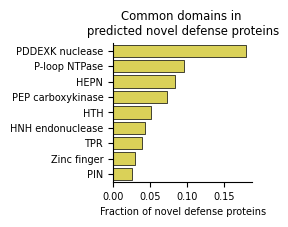

In [54]:
plt.subplots(figsize=(1.8,1.8))
sns.barplot(data=novel_pfam_clan_count.head(9), y='clan_name', x='freq', 
            color='#f0e442', linewidth=0.5, edgecolor='black')
sns.despine()
plt.xlabel('Fraction of novel defense proteins')
plt.ylabel('')
plt.title('Common domains in \npredicted novel defense proteins')
#plt.savefig('../figures/predicted_novel_defense_domains.svg', dpi=300, bbox_inches='tight')

In [55]:
select_novel_pfam_results = select_domains(novel_pfam_results)

100%|██████████| 4024/4024 [00:05<00:00, 775.89it/s]


In [62]:
random_query

16348    WP_144688757
Name: accession_stub, dtype: object

In [66]:
from IPython.display import display

In [68]:
random_query = novel_accession_stubs.sample(n=10, random_state=7).to_list()
for q in random_query: 
    print(q)
    display(select_novel_pfam_results[select_novel_pfam_results['query'] == q])

WP_144688757


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description


WP_055270356


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
35941,PF09820.12 ; AAA-ATPase_like ;,99.9,0.0,0.0,246.0,0.0,285.0,8-306,1-295 (295),WP_055270356,8.0,306.0,PF09820.12 ; AAA-ATPase_like ; Predicted AAA-A...,298.0,PF09820,CL0023,P-loop_NTPase,AAA-ATPase_like,Predicted AAA-ATPase
35942,PF08011.14 ; PDDEXK_9 ; PD-(D/,98.8,0.0,0.0,103.3,0.0,94.0,463-572,2-95 (96),WP_055270356,463.0,572.0,PF08011.14 ; PDDEXK_9 ; PD-(D/E)XK nuclease su...,109.0,PF08011,CL0236,PDDEXK,PDDEXK_9,PD-(D/E)XK nuclease superfamily


WP_072974150


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
42194,PF03925.16 ; SeqA ; SeqA prote,98.7,0.0,0.0,100.7,0.0,101.0,103-205,5-110 (111),WP_072974150,103.0,205.0,PF03925.16 ; SeqA ; SeqA protein C-terminal do...,102.0,PF03925,NaN,NaN,SeqA,SeqA protein C-terminal domain
42195,PF07510.14 ; DUF1524 ; Protein,64.8,0.29,0.000062,32.9,0.0,44.0,34-79,84-131 (135),WP_072974150,34.0,79.0,PF07510.14 ; DUF1524 ; Protein of unknown func...,45.0,PF07510,CL0263,His-Me_finger,DUF1524,Protein of unknown function (DUF1524)


WP_150028063


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description


WP_262598638


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description


WP_224470222


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description


WP_139687112


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
95435,PF07751.14 ; Abi_2 ; Abi-like,55.0,0.51,0.00012,33.5,0.0,28.0,38-65,49-76 (203),WP_139687112,38.0,65.0,PF07751.14 ; Abi_2 ; Abi-like protein,27.0,PF07751,NaN,NaN,Abi_2,Abi-like protein


WP_240561375


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
170563,PF13020.9 ; NOV_C ; Protein NO,98.5,0.0,0.0,88.6,0.0,76.0,201-285,1-79 (89),WP_240561375,201.0,285.0,"PF13020.9 ; NOV_C ; Protein NO VEIN, C-terminal",84.0,PF13020,CL0236,PDDEXK,NOV_C,"Protein NO VEIN, C-terminal"
170564,PF09821.12 ; AAA_assoc_C ; C-t,89.7,0.0093,0.000002,41.6,0.0,35.0,51-85,13-47 (119),WP_240561375,51.0,85.0,PF09821.12 ; AAA_assoc_C ; C-terminal AAA-asso...,34.0,PF09821,NaN,NaN,AAA_assoc_C,C-terminal AAA-associated domain


WP_194940657


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
138448,PF05766.15 ; NinG ; Bacterioph,97.7,0.0,0.0,73.1,0.0,62.0,150-217,80-144 (197),WP_194940657,150.0,217.0,PF05766.15 ; NinG ; Bacteriophage Lambda NinG ...,67.0,PF05766,CL0263,His-Me_finger,NinG,Bacteriophage Lambda NinG protein


WP_261736184


,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
181070,PF18722.4 ; MazG_C ; MazG C-te,100.0,0.0,0.0,563.6,0.0,184.0,188-371,4-195 (195),WP_261736184,188.0,371.0,PF18722.4 ; MazG_C ; MazG C-terminal domain,183.0,PF18722,NaN,NaN,MazG_C,MazG C-terminal domain
181071,PF12643.10 ; MazG-like ; MazG-,98.0,0.0,0.0,80.5,0.0,72.0,30-103,1-80 (88),WP_261736184,30.0,103.0,PF12643.10 ; MazG-like ; MazG-like family,73.0,PF12643,CL0231,MazG,MazG-like,MazG-like family
181075,PF12643.10 ; MazG-like ; MazG-,89.4,0.0097,0.000002,40.4,0.0,57.0,124-182,2-76 (88),WP_261736184,124.0,182.0,PF12643.10 ; MazG-like ; MazG-like family,58.0,PF12643,CL0231,MazG,MazG-like,MazG-like family


In [56]:
pfam_agg = (select_novel_pfam_results.groupby(['pfam_name', 'pfam_id', 'clan_name'], dropna=False)
            .agg(n_proteins=('query', 'nunique'))
            .reset_index())
pfam_agg['freq'] = pfam_agg['n_proteins']/len(novel_accessions)

In [57]:
unique_blacklisted_pfams = blacklisted_domains.loc[blacklisted_domains['pfam_id'].str[:2] == 'PF', 
                                                   'pfam_id'].unique()
len(unique_blacklisted_pfams)

2030

In [58]:
pfam_agg.sort_values('freq', ascending=False).head(50)

,pfam_name,pfam_id,clan_name,n_proteins,freq
762,PDDEXK_4,PF14281,PDDEXK,100,0.019073
707,Mrr_cat_2,PF13156,PDDEXK,100,0.019073
737,NinG,PF05766,His-Me_finger,90,0.017166
583,HEPN_Apea,PF18739,KNTase_C,82,0.015640
741,NucS_C,PF01939,PDDEXK,68,0.012970
648,KAP_NTPase,PF07693,P-loop_NTPase,66,0.012588
588,HEPN_RiboL-PSP,PF18735,KNTase_C,60,0.011444
14,AAA_35,PF14516,P-loop_NTPase,57,0.010872
58,ApeA_NTD1,PF18862,NaN,57,0.010872
225,DUF262,PF03235,ParBc,56,0.010681


In [59]:
select_novel_pfam_results[select_novel_pfam_results['pfam_name'] == 'CHAT']

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
4835,PF12770.10 ; CHAT ; CHAT domai,99.9,0.0,0.0,247.9,0.0,263.0,666-941,2-313 (313),WP_009543477,666.0,941.0,PF12770.10 ; CHAT ; CHAT domain,275.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
14358,PF12770.10 ; CHAT ; CHAT domai,99.8,0.0,0.0,215.3,0.0,226.0,406-633,2-256 (313),WP_017576573,406.0,633.0,PF12770.10 ; CHAT ; CHAT domain,227.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
22837,PF12770.10 ; CHAT ; CHAT domai,99.8,0.0,0.0,235.2,0.0,252.0,679-1001,12-313 (313),WP_030469729,679.0,1001.0,PF12770.10 ; CHAT ; CHAT domain,322.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
25312,PF12770.10 ; CHAT ; CHAT domai,99.6,0.0,0.0,180.3,0.0,152.0,293-455,99-262 (313),WP_037686978,293.0,455.0,PF12770.10 ; CHAT ; CHAT domain,162.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
29206,PF12770.10 ; CHAT ; CHAT domai,99.9,0.0,0.0,252.4,0.0,246.0,605-853,2-313 (313),WP_046728191,605.0,853.0,PF12770.10 ; CHAT ; CHAT domain,248.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
32454,PF12770.10 ; CHAT ; CHAT domai,99.9,0.0,0.0,245.0,0.0,240.0,620-861,2-313 (313),WP_051783839,620.0,861.0,PF12770.10 ; CHAT ; CHAT domain,241.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
33156,PF12770.10 ; CHAT ; CHAT domai,99.9,0.0,0.0,251.9,0.0,258.0,624-892,3-313 (313),WP_052316732,624.0,892.0,PF12770.10 ; CHAT ; CHAT domain,268.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
39363,PF12770.10 ; CHAT ; CHAT domai,99.8,0.0,0.0,244.3,0.0,265.0,665-946,3-313 (313),WP_067173166,665.0,946.0,PF12770.10 ; CHAT ; CHAT domain,281.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
41541,PF12770.10 ; CHAT ; CHAT domai,99.7,0.0,0.0,201.6,0.0,229.0,136-381,23-262 (313),WP_069126887,136.0,381.0,PF12770.10 ; CHAT ; CHAT domain,245.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain
48667,PF12770.10 ; CHAT ; CHAT domai,99.4,0.0,0.0,158.2,0.0,272.0,84-444,2-313 (313),WP_083175897,84.0,444.0,PF12770.10 ; CHAT ; CHAT domain,360.0,PF12770,CL0093,Peptidase_CD,CHAT,CHAT domain


Domains to highlight:
* AlbA - RNase found in SLFN family proteins. Specifically in human ribonuclease [SLFN12](https://europepmc.org/article/MED/31026779)
* Tubulin_2 - Tubulin/FtsZ [GTPase](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR036525/)
* Hsp90 - C-terminu of molecular [chaperone](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR037196/)

In [23]:
(pfam_agg[~pfam_agg['pfam_id'].isin(unique_blacklisted_pfams)]
 .sort_values('freq', ascending=False).head(50))

,pfam_name,pfam_id,clan_name,n_proteins,freq
932,SLFN_AlbA_2,PF04326,AlbA,51,0.009727
337,DUF4365,PF14280,NaN,51,0.009727
282,DUF3644,PF12358,KNTase_C,37,0.007057
49,Abi_alpha,PF14337,HTH,37,0.007057
776,PIN_8,PF18476,PIN,36,0.006866
1019,Tubulin_2,PF13809,NADP_Rossmann,34,0.006485
1085,YtxH,PF12732,NaN,32,0.006103
770,PIN_12,PF16289,PIN,30,0.005722
409,DUF6119,PF19614,NaN,27,0.005150
582,HEPN_AbiU2,PF18734,KNTase_C,26,0.004959


In [24]:
innate_results = hhpred_results[(hhpred_results['hit_name'].str[:2] == 'sp') & 
                              (hhpred_results['Prob'] > 50)].copy()
novel_innate_results = innate_results[innate_results['query'].isin(novel_accessions)]
select_novel_innate_results = select_domains(novel_innate_results)

100%|██████████| 886/886 [00:01<00:00, 691.40it/s]


In [25]:
innate_agg = (select_novel_innate_results.groupby(['hit_name'])
            .agg(n_proteins=('query', 'nunique'))
            .reset_index())
innate_agg['freq'] = innate_agg['n_proteins']/len(novel_accessions)

In [26]:
unique_blacklisted_innate = blacklisted_domains.loc[blacklisted_domains['hit_name'].str[:2] == 'sp', 
                                                   'hit_name'].unique()
len(unique_blacklisted_innate)

202

# Hits:
1. ARP3 - Overlaps with ATPase domain of HSP70, which is a chaperone that helps fold proteins under heat stress. Maybe not the most interesting
2. TBB5 - Overlaps with tubulin GTPase. Maybe not the most interesting
3. STX8 - not very strong hit and may just be a coiled coil or transmembrane region
4. FIBB - may be coiled coil of transmembrane region
5. STX4 - may be coiled coil of transmembrane region
6. TBB4B - same as TBB5
7. ACTG - Overlaps with ATPase domain of HSP70
8. LYST - WD40 repeat region that functions to facilitate protein-protein interactions
9. TRIM8 - only 8 residues align with low probability
10. FIBA - coiled-coil domain
11. ZBTB1 - zinc finger domains
12. TRI13 - low probability, short segment
13. MEFV - low probability, short segment
14. DnaJ - HSP70-like chaperone domain
15. LipA4 - Transmembrane region
16. S26A6 - STAS domain with NTP binding activities
17. PHB2 - Oligomerization domain
 18. ** RN166 - Aligns with ubiquitin interacting domain and zinc-fingers. Nearby proteins aren't necessarily ubiquitin related so hard to draw direct conclusion **
 19. STMP1 - low probability
 20. MAVS - maybe transmembrane protein. Low probability
 21. RN19B - low probability hit
 22. ZYX - low probability
 23. PP6 - overlaps with ASM3B
 24. ARP2 - low probability
 25. VAMP7 - overlaps with AbiZ
 26. MIF - Not clear what catalytic function of MIF is, but also overlaps with PDDEXK nuclease
 27. HEXI1 - low probability
 28. YTHD2 - RNA binding domain

In [80]:
pd.set_option('display.max_columns', 50)
predictions[(predictions['genomic_accession'] == 'NZ_MLBF01000056.1') & 
                   (predictions['start'] > (21408-10_000)) & 
                   (predictions['end'] < (21408+10_000))].sort_values('start', ascending=True)

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes,log_odds,predicted_defensive,defense_homolog_name,defense_homolog,assembly_stub,defense_system_gene,defense_system,defense_system_protein
1239384,WP_075366839.1|NZ_MLBF01000056.1|11889|-,7.320974e-12,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,11889,12260,-,WP_075366839.1,WP_075366839.1,NaN,hypothetical protein,NaN,NaN,DSOL_RS21545,372,123.0,NaN,-25.640278,False,NaN,False,GCF_001936615,NaN,NaN,False
1237256,WP_075366840.1|NZ_MLBF01000056.1|12262|-,1.395322e-09,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,12262,12990,-,WP_075366840.1,WP_075366840.1,NaN,phage tail family protein,NaN,NaN,DSOL_RS21550,729,242.0,NaN,-20.390141,False,NaN,False,GCF_001936615,NaN,NaN,False
1236721,WP_075366841.1|NZ_MLBF01000056.1|12987|-,5.418419e-09,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,12987,15536,-,WP_075366841.1,WP_075366841.1,NaN,phage tail tape measure protein,NaN,NaN,DSOL_RS21555,2550,849.0,NaN,-19.033462,False,NaN,False,GCF_001936615,NaN,NaN,False
1235514,WP_083642900.1|NZ_MLBF01000056.1|15594|-,2.256462e-06,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,15594,15848,-,WP_083642900.1,WP_083642900.1,NaN,hypothetical protein,NaN,NaN,DSOL_RS21560,255,84.0,NaN,-13.001710,False,NaN,False,GCF_001936615,NaN,NaN,False
1236210,WP_075366843.1|NZ_MLBF01000056.1|15905|-,2.817116e-08,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,15905,16240,-,WP_075366843.1,WP_075366843.1,NaN,hypothetical protein,NaN,NaN,DSOL_RS21565,336,111.0,NaN,-17.384967,False,NaN,False,GCF_001936615,NaN,NaN,False
1238398,WP_075366844.1|NZ_MLBF01000056.1|16313|-,1.091407e-10,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,16313,16876,-,WP_075366844.1,WP_075366844.1,NaN,hypothetical protein,NaN,NaN,DSOL_RS21570,564,187.0,NaN,-22.938384,False,NaN,False,GCF_001936615,NaN,NaN,False
1235718,WP_075366845.1|NZ_MLBF01000056.1|16893|-,3.837503e-07,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,16893,17267,-,WP_075366845.1,WP_075366845.1,NaN,hypothetical protein,NaN,NaN,DSOL_RS21575,375,124.0,NaN,-14.773273,False,NaN,False,GCF_001936615,NaN,NaN,False
1236689,WP_075366846.1|NZ_MLBF01000056.1|17267|-,5.818124e-09,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,17267,17602,-,WP_075366846.1,WP_075366846.1,NaN,HK97 gp10 family phage protein,NaN,NaN,DSOL_RS21580,336,111.0,NaN,-18.962288,False,NaN,False,GCF_001936615,NaN,NaN,False
1238753,WP_075366847.1|NZ_MLBF01000056.1|17592|-,4.579000e-11,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,17592,17909,-,WP_075366847.1,WP_075366847.1,NaN,hypothetical protein,NaN,NaN,DSOL_RS21585,318,105.0,NaN,-23.806955,False,NaN,False,GCF_001936615,NaN,NaN,False
1237708,WP_075366848.1|NZ_MLBF01000056.1|17914|-,4.892567e-10,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,17914,18222,-,WP_075366848.1,WP_075366848.1,NaN,phage head-tail connector protein,NaN,NaN,DSOL_RS21590,309,102.0,NaN,-21.438134,False,NaN,False,GCF_001936615,NaN,NaN,False


In [78]:
pd.set_option('display.max_columns', 50)
predictions[predictions['product_accession'] == 'WP_075366851.1']

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes,log_odds,predicted_defensive,defense_homolog_name,defense_homolog,assembly_stub,defense_system_gene,defense_system,defense_system_protein
1234929,WP_075366851.1|NZ_MLBF01000056.1|21408|+,0.999913,CDS,with_protein,GCF_001936615.1,Primary Assembly,unplaced scaffold,NaN,NZ_MLBF01000056.1,21408,21887,+,WP_075366851.1,WP_075366851.1,NaN,DUF2321 domain-containing protein,NaN,NaN,DSOL_RS21610,480,159.0,NaN,9.346428,True,NaN,False,GCF_001936615,NaN,NaN,False


In [97]:
hhpred_results[hhpred_results['query'] == 'WP_054968739'].sort_values('Prob', ascending=False).head(50)

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len
80846,PF01939.19 ; NucS ; Endonuclea,98.9,6.300000e-14,1.200000e-17,117.6,0.0,157.0,130-315,55-212 (226),WP_054968739,130.0,315.0,PF01939.19 ; NucS ; Endonuclease NucS,185.0
80847,PF06250.14 ; YhcG_C ; YhcG PDD,98.8,6.200000e-13,1.200000e-16,103.6,0.0,121.0,183-315,18-143 (155),WP_054968739,183.0,315.0,PF06250.14 ; YhcG_C ; YhcG PDDEXK nuclease domain,132.0
80848,PF01878.21 ; EVE ; EVE domain,96.9,7.800000e-07,1.500000e-10,64.8,0.0,132.0,2-145,1-146 (147),WP_054968739,2.0,145.0,PF01878.21 ; EVE ; EVE domain,143.0
80849,PF07788.14 ; PDDEXK_10 ; PD-(D,95.8,4.000000e-05,7.400000e-09,49.9,0.0,62.0,223-297,4-69 (74),WP_054968739,223.0,297.0,PF07788.14 ; PDDEXK_10 ; PD-(D/E)XK nuclease superfamily,74.0
80833,UniRef50_A0A7G9YI76 Cas~PD_DEx,95.7,1.000000e-05,9.700000e-09,59.4,0.0,82.0,183-272,110-195 (198),WP_054968739,183.0,272.0,UniRef50_A0A7G9YI76 Cas~PD_DExK_I_II_III_IV_V_VI_1 Nuclease YhcG n=2 Tax=cellular organisms TaxID=131567 RepID=A0A7G9YI76_9EURY,89.0
80834,UniRef50_A0A0A0GV06 RM_Type_II,93.5,2.400000e-04,2.200000e-07,60.0,0.0,64.0,221-291,528-601 (652),WP_054968739,221.0,291.0,UniRef50_A0A0A0GV06 RM_Type_II~Type_II_REases ATP-binding protein n=51 Tax=Gammaproteobacteria TaxID=1236 RepID=A0A0A0GV06_ECOLX,70.0
80850,PF14082.9 ; DUF4263 ; Domain o,92.5,2.500000e-03,4.700000e-07,47.2,0.0,98.0,185-289,3-139 (169),WP_054968739,185.0,289.0,PF14082.9 ; DUF4263 ; Domain of unknown function (DUF4263),104.0
80851,PF10539.12 ; Dev_Cell_Death ;,90.0,9.000000e-03,1.700000e-06,41.7,0.0,92.0,3-109,2-94 (123),WP_054968739,3.0,109.0,PF10539.12 ; Dev_Cell_Death ; Development and cell death domain,106.0
80852,PF06319.15 ; MmcB-like ; DNA r,87.3,2.000000e-02,3.800000e-06,41.1,0.0,70.0,184-268,12-81 (148),WP_054968739,184.0,268.0,PF06319.15 ; MmcB-like ; DNA repair protein MmcB-like,84.0
80835,UniRef50_A0A2T5PE13 Shedu~SduA,84.7,7.000000e-03,6.700000e-06,47.9,0.0,120.0,184-313,296-452 (479),WP_054968739,184.0,313.0,UniRef50_A0A2T5PE13 Shedu~SduA DUF4263 domain-containing protein n=4 Tax=Pseudomonas TaxID=286 RepID=A0A2T5PE13_9PSED,129.0


In [96]:
(select_novel_innate_results[select_novel_innate_results['hit_name']
                              == ('sp|Q9Y5A9|YTHD2_HUMAN YTH domain-containing family protein 2 OS=Homo sapiens OX=9606 GN=YTHDF2 PE=1 SV=2')]
 .sort_values('Prob', ascending=False))
                            

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len
80845,sp|Q9Y5A9|YTHD2_HUMAN YTH doma,69.1,0.038,0.000044,43.2,0.0,137.0,2-154,411-551 (579),WP_054968739,2.0,154.0,sp|Q9Y5A9|YTHD2_HUMAN YTH domain-containing family protein 2 OS=Homo sapiens OX=9606 GN=YTHDF2 PE=1 SV=2,152.0


In [28]:
pd.set_option('display.max_colwidth', 150)
(innate_agg[~innate_agg['hit_name'].isin(unique_blacklisted_innate)]
.sort_values('freq', ascending=False).head(50))

,hit_name,n_proteins,freq
40,sp|P61158|ARP3_HUMAN Actin-related protein 3 OS=Homo sapiens OX=9606 GN=ACTR3 PE=1 SV=3,13,0.002479
21,sp|P07437|TBB5_HUMAN Tubulin beta chain OS=Homo sapiens OX=9606 GN=TUBB PE=1 SV=2,9,0.001717
104,sp|Q9UNK0|STX8_HUMAN Syntaxin-8 OS=Homo sapiens OX=9606 GN=STX8 PE=1 SV=2,5,0.000954
18,sp|P02675|FIBB_HUMAN Fibrinogen beta chain OS=Homo sapiens OX=9606 GN=FGB PE=1 SV=2,5,0.000954
46,sp|Q12846|STX4_HUMAN Syntaxin-4 OS=Homo sapiens OX=9606 GN=STX4 PE=1 SV=2,4,0.000763
43,sp|P68371|TBB4B_HUMAN Tubulin beta-4B chain OS=Homo sapiens OX=9606 GN=TUBB4B PE=1 SV=1,3,0.000572
42,"sp|P63261|ACTG_HUMAN Actin, cytoplasmic 2 OS=Homo sapiens OX=9606 GN=ACTG1 PE=1 SV=1",3,0.000572
82,sp|Q99698|LYST_HUMAN Lysosomal-trafficking regulator OS=Homo sapiens OX=9606 GN=LYST PE=1 SV=3,3,0.000572
85,sp|Q9BZR9|TRIM8_HUMAN E3 ubiquitin-protein ligase TRIM8 OS=Homo sapiens OX=9606 GN=TRIM8 PE=1 SV=2,3,0.000572
17,sp|P02671|FIBA_HUMAN Fibrinogen alpha chain OS=Homo sapiens OX=9606 GN=FGA PE=1 SV=2,3,0.000572


In [19]:
categorized_predictions = (predictions.merge(merged_predictions[['protein_context_id', 
                                                                 'hit_category', 'hit_name', 'q_cov', 'Prob']], 
                                             how='left', on='protein_context_id'))

In [23]:
novel_pfam_results

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
0,PF12732.10 ; YtxH ; YtxH-like,99.4,6.600000e-18,1.200000e-21,97.3,0.0,97.0,8-107,1-100 (103),WP_000030297,8.0,107.0,PF12732.10 ; YtxH ; YtxH-like protein,99.0,PF12732,NaN,NaN,YtxH,YtxH-like protein
1,PF07889.15 ; DUF1664 ; Protein,96.0,2.500000e-05,4.400000e-09,44.1,0.0,85.0,32-117,32-116 (122),WP_000030297,32.0,117.0,PF07889.15 ; DUF1664 ; Protein of unknown func...,85.0,PF07889,NaN,NaN,DUF1664,Protein of unknown function (DUF1664)
2,PF06295.15 ; DUF1043 ; Protein,95.9,3.600000e-05,6.400000e-09,43.8,0.0,18.0,11-28,1-18 (130),WP_000030297,11.0,28.0,PF06295.15 ; DUF1043 ; Protein of unknown func...,17.0,PF06295,NaN,NaN,DUF1043,Protein of unknown function (DUF1043)
3,PF19664.2 ; DUF6167 ; Family o,94.8,2.900000e-04,5.000000e-08,37.1,0.0,36.0,3-38,3-41 (86),WP_000030297,3.0,38.0,PF19664.2 ; DUF6167 ; Family of unknown functi...,35.0,PF19664,NaN,NaN,DUF6167,Family of unknown function (DUF6167)
4,PF06785.14 ; UPF0242 ; Unchara,93.5,1.300000e-03,2.200000e-07,39.4,0.0,26.0,89-114,137-162 (192),WP_000030297,89.0,114.0,PF06785.14 ; UPF0242 ; Uncharacterised protein...,25.0,PF06785,NaN,NaN,UPF0242,Uncharacterised protein family (UPF0242) N-ter...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185643,PF10058.12 ; zinc_ribbon_10 ;,54.6,6.700000e-01,1.200000e-04,26.6,0.0,28.0,2-32,20-47 (49),YP_498763,2.0,32.0,PF10058.12 ; zinc_ribbon_10 ; Predicted integr...,30.0,PF10058,CL0167,Zn_Beta_Ribbon,zinc_ribbon_10,Predicted integral membrane zinc-ribbon metal-...
185644,PF13945.9 ; NST1 ; Salt tolera,51.1,8.800000e-01,1.500000e-04,33.8,0.0,12.0,22-33,130-141 (181),YP_498763,22.0,33.0,PF13945.9 ; NST1 ; Salt tolerance down-regulator,11.0,PF13945,NaN,NaN,NST1,Salt tolerance down-regulator
185645,PF15956.8 ; DUF4760 ; Domain o,96.2,9.700000e-06,2.300000e-09,58.6,0.0,71.0,181-251,74-145 (145),YP_500030,181.0,251.0,PF15956.8 ; DUF4760 ; Domain of unknown functi...,70.0,PF15956,NaN,NaN,DUF4760,Domain of unknown function (DUF4760)
185671,PF09517.13 ; RE_Eco29kI ; Eco2,90.9,5.300000e-03,1.200000e-06,50.2,0.0,22.0,368-389,95-116 (165),YP_500939,368.0,389.0,PF09517.13 ; RE_Eco29kI ; Eco29kI restriction ...,21.0,PF09517,CL0418,GIY-YIG,RE_Eco29kI,Eco29kI restriction endonuclease


In [ ]:
novel_pfam_clan_count = (novel_pfam_clans.groupby('clan_name')
                         .agg(count=('query', 'count'))
                         .rename(index={'P-loop_NTPase': 'P-loop NTPase', 
                                        'PDDEXK': 'PDDEXK nuclease', 
                                        'PEP-carboxyk': 'PEP carboxykinase',
                                        'Met_repress': 'RHH antitoxin DNA binding', 
                                        'KNTase_C': 'HEPN', 
                                        'His-Me_finger': 'HNH endonuclease', 
                                        'Zn_Beta_Ribbon': 'Zinc finger'})
                         .sort_values('count', ascending=False)
                         .reset_index())
novel_pfam_clan_count['freq'] = novel_pfam_clan_count['count']/len(novel_accessions)